# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

In [2]:
sp500_data = conn.raw_sql("""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '1990-01-01'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [3]:
risk_free_data = conn.raw_sql('''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '1990-01-01'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8748,2024-09-24,0.00020
8749,2024-09-25,0.00020
8750,2024-09-26,0.00020
8751,2024-09-27,0.00020


### COMPANY DATA

In [4]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

company_name = 'NVIDIA CORP'

comps[comps['company_name'] == f'{company_name}']

,permno,company_name
8,86580,NVIDIA CORP


In [5]:
# Using NVIDIA as example to figure out the algorithm.

link = conn.raw_sql('''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = 86580;
''')

link

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,117768,P,01,LU,86580.0,16382.0,1.0,1999-01-22,None


In [6]:
company_gvkey = link['gvkey'][0]
company_permno = str(link['lpermno'][0])

In [7]:
company_fin_data = conn.raw_sql(f'''
SELECT
    datadate AS date,
    atq AS total_assets,  -- Total Assets
    chq AS cash_holdings,  -- Cash and Short-Term Investments
    rdq AS reporting_date -- Date of which information was reported
FROM
    comp.fundq
WHERE
    gvkey = '{company_gvkey}'
    AND datadate >= '1990-01-01'  -- Ensure data is after the link start date
''')

company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])

start_date = company_fin_data['date'].min()
end_date = company_fin_data['date'].max()
all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
full_range_df = pd.DataFrame({'date': all_months})

company_fin_data = pd.merge(full_range_df, company_fin_data, on='date', how='left')

company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
company_fin_data['month_end'] = company_fin_data['date']

company_fin_data

# company['date'] = company['reporting_date'] # backtest logic TODO



,date,total_assets,cash_holdings,reporting_date,month_start,month_end
0,1996-03-31,NaN,NaN,NaT,1996-03-01,1996-03-31
1,1996-04-30,NaN,NaN,NaT,1996-04-01,1996-04-30
2,1996-05-31,NaN,NaN,NaT,1996-05-01,1996-05-31
3,1996-06-30,NaN,NaN,NaT,1996-06-01,1996-06-30
4,1996-07-31,NaN,NaN,NaT,1996-07-01,1996-07-31
...,...,...,...,...,...,...
336,2024-03-31,NaN,NaN,NaT,2024-03-01,2024-03-31
337,2024-04-30,77072.0,7587.0,2024-05-22,2024-04-01,2024-04-30
338,2024-05-31,NaN,NaN,NaT,2024-05-01,2024-05-31
339,2024-06-30,NaN,NaN,NaT,2024-06-01,2024-06-30


In [8]:
# Forward Fill

company_fin_data = company_fin_data.ffill().dropna()

In [9]:
company_stock_prcs = conn.raw_sql(f'''
SELECT
    date,
    prc AS stock_price,
    ret AS stock_return  -- Stock returns from CRSP
    -- prc * shrout AS market_cap  -- Market cap
FROM
    crsp.msf
WHERE
    permno = {company_permno}
''')

company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

company_stock_prcs

,date,stock_price,stock_return
0,1998-12-31,NaN,NaN
1,1999-01-29,19.00000,NaN
2,1999-02-26,21.93750,0.154605
3,1999-03-31,21.12500,-0.037037
4,1999-04-30,18.25000,-0.136095
...,...,...,...
296,2023-08-31,493.54999,0.056196
297,2023-09-29,434.98999,-0.118570
298,2023-10-31,407.79999,-0.062507
299,2023-11-30,467.70001,0.146886


In [10]:
# Create new columns with just year and month
company_fin_data['year_month'] = company_fin_data['date'].dt.strftime('%Y-%m')
company_stock_prcs['year_month'] = company_stock_prcs['date'].dt.strftime('%Y-%m')

company = pd.merge(company_fin_data, company_stock_prcs, on='year_month')

company.drop(columns=['year_month', 'date_y'], axis=1, inplace=True)
company.rename(columns={'date_x':'date'}, inplace=True)

# company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='inner')

company

,date,total_assets,cash_holdings,reporting_date,month_start,month_end,stock_price,stock_return
0,2007-04-30,2800.868,678.951,2007-05-10,2007-04-01,2007-04-30,32.89000,0.142807
1,2007-05-31,2800.868,678.951,2007-05-10,2007-05-01,2007-05-31,34.63900,0.053177
2,2007-06-30,2800.868,678.951,2007-05-10,2007-06-01,2007-06-30,41.31000,0.192586
3,2007-07-31,3036.267,914.745,2007-08-09,2007-07-01,2007-07-31,45.76000,0.107722
4,2007-08-31,3036.267,914.745,2007-08-09,2007-08-01,2007-08-31,51.16000,0.118007
...,...,...,...,...,...,...,...,...
196,2023-08-31,49555.000,5783.000,2023-08-23,2023-08-01,2023-08-31,493.54999,0.056196
197,2023-09-30,49555.000,5783.000,2023-08-23,2023-09-01,2023-09-30,434.98999,-0.118570
198,2023-10-31,54148.000,5519.000,2023-11-21,2023-10-01,2023-10-31,407.79999,-0.062507
199,2023-11-30,54148.000,5519.000,2023-11-21,2023-11-01,2023-11-30,467.70001,0.146886


In [11]:
def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
    mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
    return agg_func(daily_data.loc[mask, column])

company['snp_return'] = company.apply(
    lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'daily_return', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

company['rf_rate'] = company.apply(
    lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

company.drop(columns=['month_start', 'month_end'], axis=1, inplace=True)

# CALCULATIONS (CASH-HEDGING & RETURNS)

In [12]:
company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])

### $ b_{t}^{i} $ - return on cash between periods

In [13]:
# the paper calculates it in a pretty complicated method, we'll start like this

company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
company['b_it'] = ( company['cash_holdings'] - company['cash_holdings_t_minus_1'] ) / company['cash_holdings_t_minus_1']

### $ e_{t}^{i} $ - cash hedged returns

In [14]:
# calculate the cash-hedged return (e_it)

company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

company

,date,total_assets,cash_holdings,reporting_date,stock_price,stock_return,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return
0,2007-04-30,2800.868,678.951,2007-05-10,32.89000,0.142807,0.043292,0.004409,0.242407,NaN,NaN,NaN
1,2007-05-31,2800.868,678.951,2007-05-10,34.63900,0.053177,0.032547,0.003967,0.242407,678.951,0.000000,0.070192
2,2007-06-30,2800.868,678.951,2007-05-10,41.31000,0.192586,-0.017817,0.003998,0.242407,678.951,0.000000,0.254208
3,2007-07-31,3036.267,914.745,2007-08-09,45.76000,0.107722,-0.031985,0.003998,0.301273,678.951,0.347292,0.004426
4,2007-08-31,3036.267,914.745,2007-08-09,51.16000,0.118007,0.012864,0.004148,0.301273,914.745,0.000000,0.168889
...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023-08-31,49555.000,5783.000,2023-08-23,493.54999,0.056196,-0.017717,0.004610,0.116699,5783.000,0.000000,0.063620
197,2023-09-30,49555.000,5783.000,2023-08-23,434.98999,-0.118570,-0.048720,0.004208,0.116699,5783.000,0.000000,-0.134235
198,2023-10-31,54148.000,5519.000,2023-11-21,407.79999,-0.062507,-0.021980,0.004630,0.101924,5783.000,-0.045651,-0.064420
199,2023-11-30,54148.000,5519.000,2023-11-21,467.70001,0.146886,0.089178,0.004419,0.101924,5519.000,0.000000,0.163556


# BETA CALCULATION

Seems like in some instances cash_hedged_returns is getting super over inflated. Ideally, that is what we want! But will need to make sure the raise in risk is also reflected.

Next steps:
* Calculate Beta for non-cash assets in NVIDIA
* Use above data to test returns in cash-hedged for NVIDIA over time (long-only) 
* (etc)

Calculating Stock Beta and Cash-Hedged Beta (PiT).

In [15]:
window = 65 # months

def calculate_rolling_beta(stock_return, market_return, window):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

In [16]:

company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'], window)
company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'], window)
company['snp_beta'] = calculate_rolling_beta(company['snp_return'], company['snp_return'], window)

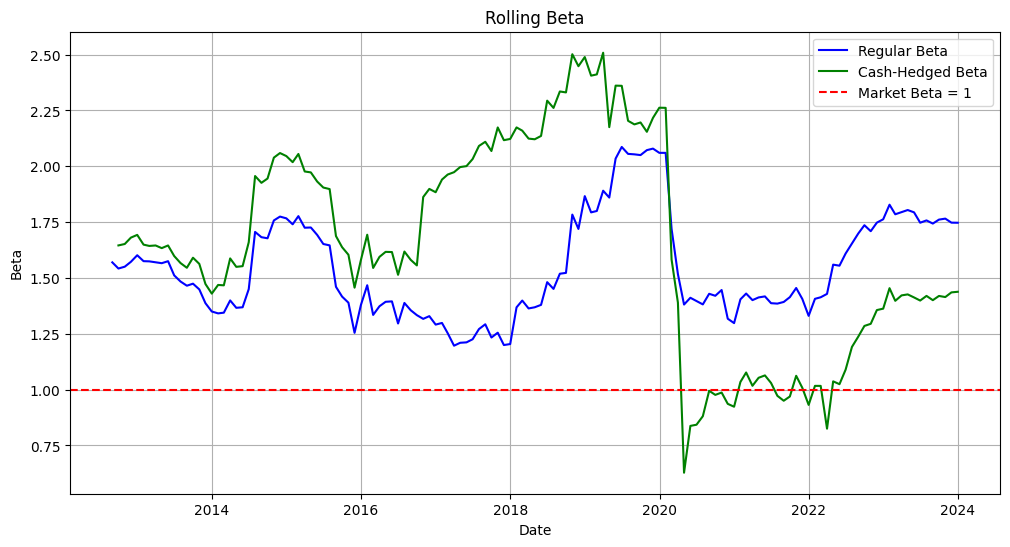

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['company_beta'], label='Regular Beta', color='blue')
plt.plot(company['date'], company['cash_hedged_beta'], label='Cash-Hedged Beta', color='green')
plt.axhline(1, color='red', linestyle='--', label='Market Beta = 1')
plt.title('Rolling Beta')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
# plt.ylim(-5, 5)
plt.grid()
plt.show()


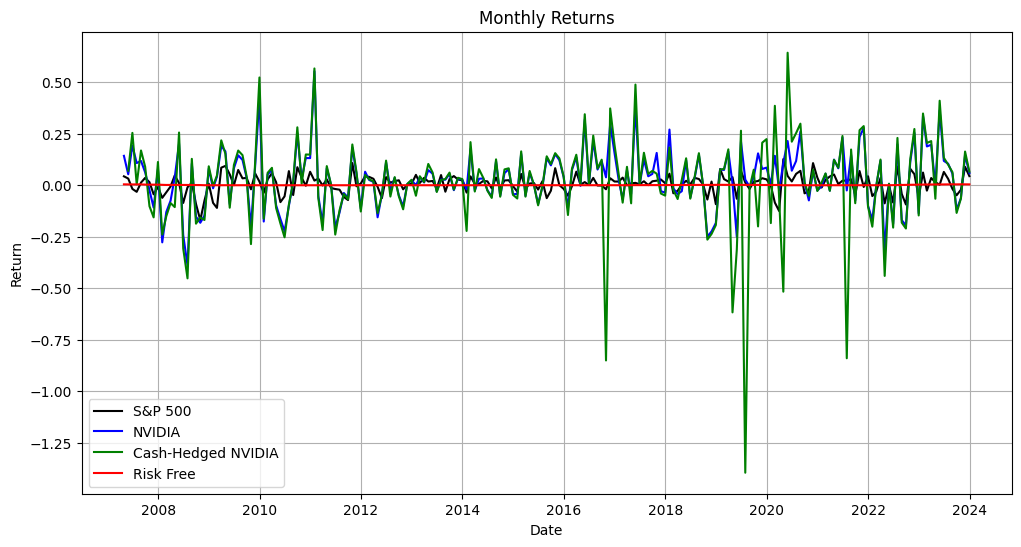

In [18]:

plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['snp_return'], label='S&P 500', color='black')
plt.plot(company['date'], company['stock_return'], label='NVIDIA', color='blue')
plt.plot(company['date'], company['cash_hedged_return'], label='Cash-Hedged NVIDIA', color='green')
plt.plot(company['date'], company['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [19]:
company['snp_cum_return'] = (1 + company['snp_return']).cumprod() - 1
company['company_cum_return'] = (1 + company['stock_return']).cumprod() - 1
company['cash_hedged_cum_return'] = (1 + company['cash_hedged_return']).cumprod() - 1
company['rf_cum_return'] = (1 + company['rf_rate']).cumprod() - 1

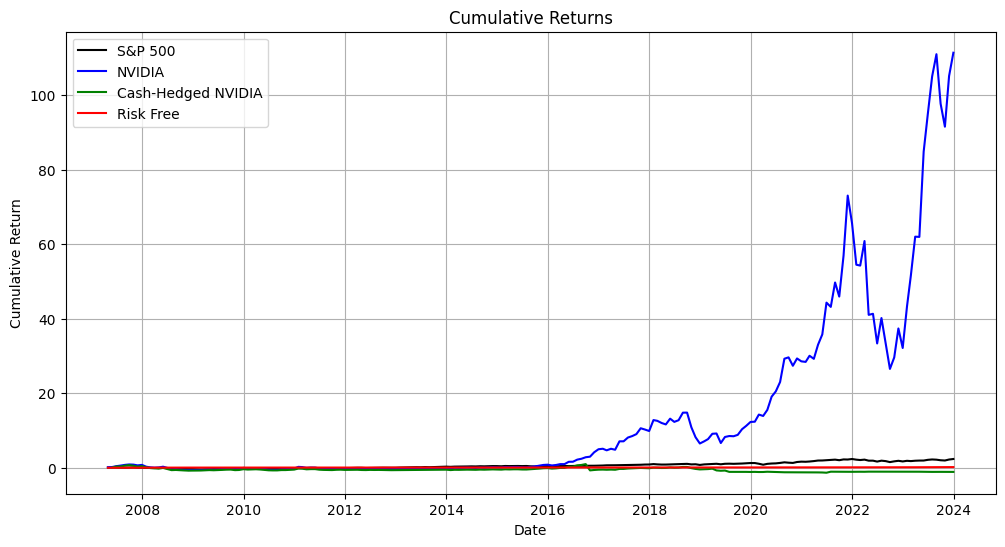

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['snp_cum_return'], label='S&P 500', color='black')
plt.plot(company['date'], company['company_cum_return'], label='NVIDIA', color='blue')
plt.plot(company['date'], company['cash_hedged_cum_return'], label='Cash-Hedged NVIDIA', color='green')
plt.plot(company['date'], company['rf_cum_return'], label='Risk Free', color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

In [21]:
def sharpe(ret):
    temp = pd.DataFrame()
    temp["stock_excess_return"] = company[f"{ret}"] - company["rf_rate"]

    average_excess_return = temp["stock_excess_return"].mean()
    std_excess_return = temp["stock_excess_return"].std()

    return average_excess_return / std_excess_return

print(f"{company_name} Sharpe Ratio:", sharpe('stock_return'))
print(f"Cash Hedged {company_name} Sharpe Ratio:", sharpe('cash_hedged_return'))
print("SNP500 Sharpe Ratio:", sharpe('snp_return'))

NVIDIA CORP Sharpe Ratio: 0.23393314730972112
Cash Hedged NVIDIA CORP Sharpe Ratio: 0.05712774705112395
SNP500 Sharpe Ratio: 0.1358355920904319
